# Micrograd

反向传播的本质就是只需要每次计算在计算图中一个局部、也就是一个运算符号所决定的导数，通过链式法则从后往前可以算出输出的值（后面的值）关于输入的值（前面的值）的导数

而在神经网络中，我们需要计算的梯度是最后的输出关于所有权重的导数，所以我们需要存储grad启示指的是输出关于计算图中每个权重节点的导数

### engine.py
定义了value类，也就是可以用于计算的值，和相应的计算法则的方法

计算方法：
- __add__
- __mul__
- __pow__
- relu

反向传播：
- backward

In [53]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):  
        # children是个元组，储存运算得到这个value的value。op是指这个value是通过什么运算得到的
        self.data = data # 该对象的值
        self.grad = 0  # 储存梯度
        # internal variables used for autograd graph construction
        self._backward = lambda: None  # 默认没有功能。但是如果该value是通过运算得到的，运行该函数的结果是children节点的grad可以被更新
        self._prev = set(_children) # 如果是叶子节点，就没有children
        self._op = _op # the op that produced this node, for graphviz / debugging / etc


    # 计算方法
    def __add__(self, other): # 加法,使得可以使用+操作。a+b和a._add_(b)是同一个意思
        other = other if isinstance(other, Value) else Value(other) # other既可以也是一个value，也可以是一个数
        out = Value(self.data + other.data, (self, other), '+')   # (self, other)是children, +是_op

        # _backward函数是一个闭包函数。当_backward函数在__add__方法内部被定义时，并不立即执行，但是Python记录了函数体代码，还捕获了当时的作用域链，即使__add__方法执行完毕返回后，这些变量（self, other, out）依然被_backward函数保留在它的闭包环境中。
        # 所以在重新调用out._backward()时，计算机能记住self和other是谁，并更新self、other的grad
        
        # 定义加法的导函数。根据链式法则，元素self、other的grad是输出out的grad乘以1。
        def _backward():  
            self.grad += 1 * out.grad 
            # +=中+的意思是要累积梯度，防止被多次调用时被重写。因为根据链式法则，df(g1,g2)/dx = df/dg1 * dg1/dx + df/dg2 * dg2/dx
            other.grad += 1 * out.grad
        out._backward = _backward  

        return out

    def __mul__(self, other): # 乘法
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward(): # 定义乘法的导函数。元素self、other的导数是输出out的导数乘以另一个
            self.grad += other.data * out.grad           
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out


    # 反向传播方法

    def backward(self):
        # topological order all of the children in the graph
        # 这个函数的操作能够求当前这个节点关于之前所有元素的grad
        # 具体思路是：画了一个拓扑图，根据计算图中计算优先级的顺序，一个一个输出节点，也就是用递归的方法从最早的输入开始，在列表中依次加入...子节点的子节点的子节点、子节点的子节点、子节点。然后再从后往前用_backward()一层一层更新子节点的grad
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1  # 输出关于自己的导数肯定是1
        # 遍历的时候反过来，从最后的输出开始往回遍历子节点
        for v in reversed(topo):
            v._backward() # 一层一层更新子节点的grad

    def __neg__(self): # -self
        return self * -1


    # 当左操作数不支持+运算时，Python 会自动调用右操作数的 __r*__方法，例如2._add_(a)时2只是一个数，不能成功运行，但是有__radd__辅助完成
    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1


    def __repr__(self): # 直接打印这个value时会输出的东西
        return f"Value(data={self.data}, grad={self.grad})"

### 查看计算图

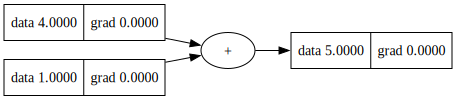

In [ ]:
from graphviz import Digraph
# pip install graphviz。要渲染生成的可在Graphviz软件使用DOT源代码，还需要安装Graphviz，并确保包含dot可执行文件的目录在系统路径上。


def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

# 调用方法
v = Value(1) + Value(4)
draw_dot(v)

### nn.py
神经网络的基本元素

- neuron：接受nin个输入，最后只有一个输出
- layer：包含多个neuron，接受nin个输入，输出数量nout等于neuron数量
- MLP：包含多个layer，接受nin个输入，输出数量一般为1个

In [86]:
import random

class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):

    def __init__(self, nin, nonlin=True):  # nin是输入的数量
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]  # 权重随机生成
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x): # 调用该类的时候会运行的东西,需要输入x，x应该是一个列表
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b) # w1*x1 + w2*x2 + ... + b
        return act.relu() if self.nonlin else act

    def parameters(self): # 收集所有的权重，便于之后梯度下降优化
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):

    def __init__(self, nin, nout, **kwargs):  # nout是输出数量，也就是layer中Neuron的数量。nin是每个Neuron的输入数量
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]   # 输出为layer中每个neuron输出的值所构成的列表。输入x是个列表，长度等于nin
        return out[0] if len(out) == 1 else out 


    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()] # 收集每个neuron中的每个权重

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):

    def __init__(self, nin, nouts):   # e.g. n = MLP(3,[4,4,1])是一个3个输入、中间2层都是4个神经元、最后输出1个数的MLP
        sz = [nin] + nouts  # sz = [3,4,4,1]
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))] # 第一层为Layer(3,4)，4个neuron，第二层Layer(4,4)，4个neuron，第三层Layer(4,1)，1个neuron

    def __call__(self, x):  # 调用一次就计算每个layer所有neuron的输出值。for循环的意思是一层一层输入并输出，最后输出最后一层的值。x是输入的列表，长度等于nin
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()] # 收集每个layer中的权重
    
    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"


In [114]:
# 例子。包括怎么训练
n = MLP(3,[4,4,1])
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]
ys = [1.0,-1.0,-1.0,1.0] # 真实值

for k in range(1000):
    # 正向传播
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for yout, ygt in zip(ypred, ys)) # 计算损失，ygt是指y_groundtruth
    
    # 反向传播
    for p in n.parameters():
        p.grad = 0 # 清空梯度
    loss.backward()

    # 更新权重
    for p in n.parameters():
        p.data += -0.05 * p.grad
    
    print(k, loss.data)



0 3.284570483070937
1 3.0736967726524647
2 2.8435871586075314
3 2.7501258470413465
4 2.7107323663488354
5 2.690180891461317
6 2.6808383066083517
7 2.6739558439987237
8 2.6704011239912413
9 2.6686073799922694
10 2.667679764017903
11 2.6671965317724733
12 2.666944020672843
13 2.6668119061447206
14 2.6667427349175457
15 2.666706510268148
16 2.6666875366536797
17 2.66667759839376
18 2.666672392675585
19 2.6666696659112263
20 2.666668237635199
21 2.66666748951477
22 2.6666670976582343
23 2.666666892410299
24 2.666666784905551
25 2.666666728597039
26 2.6666666991040597
27 2.666666683656431
28 2.666666675565399
29 2.666666671327553
30 2.666666669107895
31 2.6666666679453064
32 2.6666666673363784
33 2.66666666701744
34 2.6666666668503907
35 2.6666666667628953
36 2.6666666667170684
37 2.666666666693065
38 2.6666666666804932
39 2.6666666666739087
40 2.6666666666704595
41 2.6666666666686534
42 2.6666666666677075
43 2.666666666667212
44 2.6666666666669525
45 2.666666666666816
46 2.6666666666667447

In [115]:
ypred


[Value(data=0.3333333333333332, grad=-1.3333333333333335),
 Value(data=-1.0, grad=0.0),
 Value(data=0.3333333333333332, grad=2.6666666666666665),
 Value(data=0.3333333333333332, grad=-1.3333333333333335)]

pytorch实现方法
